In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

### import CSV
CSV with cell trajectrories created as follows:
- Cellpose segmentation
- TrackMate tracking of segmented images
- Random Forest rough segmentation of deviding cells `nematics\segmentation_WekaLike.py`
- Detection of division events with `nematics\journals\cell_divisions_cellpose_TrackMate.ipynb`

In [2]:
# df = pd.read_csv(r"C:\Users\victo\Downloads\SB_lab\HBEC\s2(120-919)\Tracking\spots_100_500_wdivs.csv")
df = pd.read_csv(r"C:\Users\victo\Downloads\SB_lab\HBEC\s2(120-919)\Tracking\spots_100_500_3s_wdiv.csv")

In [3]:
df.keys()

Index(['Unnamed: 0.1', 'Unnamed: 0', 'index', 'ID', 'TRACK_ID', 'POSITION_X',
       'POSITION_Y', 'POSITION_Z', 'POSITION_T', 'FRAME', 'RADIUS',
       'ELLIPSE_X0', 'ELLIPSE_Y0', 'ELLIPSE_MAJOR', 'ELLIPSE_MINOR',
       'ELLIPSE_THETA', 'ELLIPSE_ASPECTRATIO', 'AREA', 'PERIMETER',
       'CIRCULARITY', 'SOLIDITY', 'SHAPE_INDEX', 'DIVIDING',
       'INTENSITY_UNNORM', 'DIVISION_T35', 'count', 'T0'],
      dtype='object')

See [xgboost code example](https://www.kaggle.com/code/robikscube/time-series-forecasting-with-machine-learning-yt)

In [ ]:
%matplotlib qt
params = ['AREA', 'PERIMETER','SHAPE_INDEX', 'CIRCULARITY', 'RADIUS']
ids = df["TRACK_ID"][df['T0']==1].unique()

colors = {0: (.1,.1,.1,.01), 1: (.9,.1,.1, .3)}
df['color'] = df["T0"].map(colors)

fig, axs  = plt.subplots(1,len(params),figsize=(20, 5))
axs = axs.ravel()
 
for num,id in enumerate(ids[1000::50]):
    i_df = df[df["TRACK_ID"]==id]
    if not any(i_df["T0"][:10]) and len(i_df["T0"])>40:
        for ax,param in zip(axs, params):            
            # i_df.plot(x="POSITION_T", y=param,
            #     style='-', figsize=(20, 5), ax=ax, title=param, alpha=.5)
            i_df.plot.scatter(x="POSITION_T", y=param, c=i_df['color'], s=10, ax=ax,)
            ax.set_xlabel('$Frame$')
        if num>500:
            break


plt.tight_layout()


In [ ]:
df.keys()

## Train / Test Split

In [4]:
FEATURES = ['AREA', 'PERIMETER','SHAPE_INDEX', 'CIRCULARITY', 'RADIUS','INTENSITY_UNNORM']
TARGET = 'T0'
X, y = df[FEATURES], df[TARGET]

In [5]:
from sklearn.model_selection import train_test_split

# Split X and y into training and testing sets with 80/20 ratio
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Split the testing set into testing and validation sets with 50/50 ratio
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

# Verify the shape of training, testing, and validation sets
print("Training set size:", X_train.shape)
print("Testing set size:", X_test.shape)
print("Validation set size:", X_val.shape)

Training set size: (1572592, 6)
Testing set size: (196574, 6)
Validation set size: (196575, 6)


In [6]:
reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                       n_estimators=300,
                       early_stopping_rounds=50,
                       objective='reg:linear',
                       max_depth=5,
                       learning_rate=0.01)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=50)

[19:02:37] WARNING: c:\users\dev-admin\croot2\xgboost-split_1675461376218\work\src\objective\regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:0.49557	validation_1-rmse:0.49556
[50]	validation_0-rmse:0.32821	validation_1-rmse:0.32794
[100]	validation_0-rmse:0.23925	validation_1-rmse:0.23868
[150]	validation_0-rmse:0.19685	validation_1-rmse:0.19604
[200]	validation_0-rmse:0.17881	validation_1-rmse:0.17784
[250]	validation_0-rmse:0.17171	validation_1-rmse:0.17066
[299]	validation_0-rmse:0.16905	validation_1-rmse:0.16798


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=300, n_jobs=None, num_parallel_tree=None,
             objective='reg:linear', predictor=None, ...)

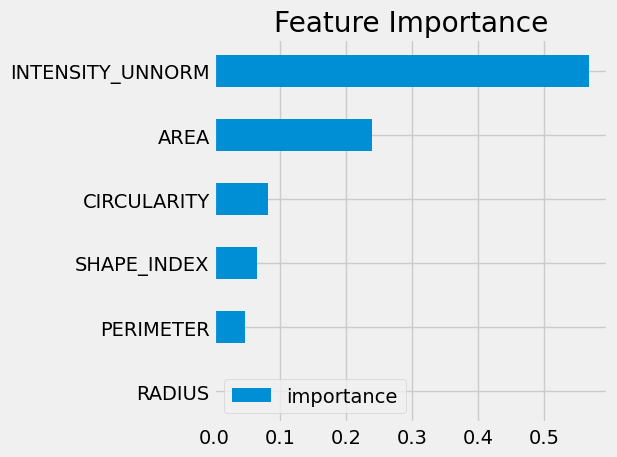

In [7]:
%matplotlib inline
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.tight_layout()

In [ ]:
test['prediction'] = reg.predict(X_test)
df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)